In [41]:
pip install pyspark

In [186]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LinearSVC

# Initialize Spark session
spark = SparkSession.builder.appName("EarthquakeAnalysis").getOrCreate()

# Load data
df_main = spark.read.csv("s3://bigdata-earthquake/usgs_current.csv", header=True, inferSchema=True)
df_current = spark.read.csv("usgs_current.csv", header=True, inferSchema=True)

# Handling null values - Assuming replacement with median is acceptable
def fill_with_median(df, include=set()):
    stats = df.agg(*(F.percentile_approx(c, 0.5).alias(c) for c in include))
    return df.na.fill(stats.first().asDict())

numeric_cols = ['latitude', 'longitude', 'depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst']
df_main = fill_with_median(df_main, include=numeric_cols)
df_current = fill_with_median(df_current, include=numeric_cols)

# Remove unnecessary columns
columns_to_drop = ['time', 'id', 'updated', 'place', 'net', 'locationSource', 'magSource', 'status']
df_main = df_main.drop(*columns_to_drop)
df_current = df_current.drop(*columns_to_drop)

# Handle categorical columns - OneHotEncoding after StringIndexing
categorical_columns = ['magType', 'type']
stages = []  # stages in our Pipeline

for categorical_col in categorical_columns:
    string_indexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "Index")
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[categorical_col + "OHE"])
    stages += [string_indexer, encoder]

# Assemble numeric columns into a features vector
assembler_inputs = [c + "OHE" for c in categorical_columns] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# Create a Pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df_main_transformed = pipeline_model.transform(df_main)

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df_current_transformed = pipeline_model.transform(df_current)

# Select the output and label columns
final_main_df = df_main_transformed.select(col("features"), col("mag").alias("label"))
final_current_df = df_current_transformed.select(col("features"), col("mag").alias("label"))

#SVM

In [245]:

# Define evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol="label")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="label")

# Define the SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")

# Define the parameter grid for hyperparameter tuning
param_grid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1]) \
    .addGrid(svm.maxIter, [10, 50, 100]) \
    .build()

# Set up the cross-validator
cross_validator_svm = CrossValidator(
    estimator=svm,
    estimatorParamMaps=param_grid_svm,
    evaluator=binary_evaluator,
    numFolds=5
)

# Fit the cross-validated model
cv_model_svm = cross_validator_svm.fit(train_current_data)

# Make predictions
predictions_svm = cv_model_svm.bestModel.transform(test_current_data)

# Evaluate metrics
accuracy_svm = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "accuracy"})
f1_score_svm = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "f1"})
precision_svm = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "weightedPrecision"})
recall_svm = multiclass_evaluator.evaluate(predictions_svm, {multiclass_evaluator.metricName: "weightedRecall"})

# Print the results
print("Support Vector Machine (SVM) Results:")
print(f"Accuracy: {accuracy_svm}")
print(f"F1 Score: {f1_score_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")

# Generating and printing the confusion matrix
confusion_matrix_svm = predictions_svm.groupBy("label").pivot("prediction", [0, 1]).count()
confusion_matrix_svm.show()

# Best model parameters
best_model_svm = cv_model_svm.bestModel
print("Best Model Parameters for SVM:")
print(f" - RegParam: {best_model_svm._java_obj.getRegParam()}")
print(f" - MaxIter: {best_model_svm._java_obj.getMaxIter()}")


Support Vector Machine (SVM) Results:
Accuracy: 0.9230769230769231
F1 Score: 0.9286510590858416
Precision: 0.9387057387057387
Recall: 0.9230769230769231
+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    1|  1|  4|
|    0| 44|  3|
+-----+---+---+

Best Model Parameters for SVM:
 - RegParam: 0.01
 - MaxIter: 10


In [187]:



# Assume binary classification: 1 if magnitude > threshold, 0 otherwise
threshold = 4.5  # Adjust the threshold according to your analysis needs
df_main_transformed = df_main_transformed.withColumn("binaryLabel", when(col("mag") > threshold, 1).otherwise(0))
df_current_transformed = df_current_transformed.withColumn("binaryLabel", when(col("mag") > threshold, 1).otherwise(0))

# Update the data split with the new binary labels
train_main_data, test_main_data = df_main_transformed.select("features", col("binaryLabel").alias("label")).randomSplit([0.7, 0.3], seed=42)
train_current_data, test_current_data = df_current_transformed.select("features", col("binaryLabel").alias("label")).randomSplit([0.7, 0.3], seed=42)
train_main_data = test_current_data

In [188]:
# Create the SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model
svm_model = svm.fit(train_main_data)

# Make predictions
predictions = svm_model.transform(test_current_data)


In [240]:
# Evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Calculate raw accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.9230769230769231
F1 Score: 0.9286510590858416
Precision: 0.9387057387057387
Recall: 0.9230769230769231


# logistic regression

In [244]:

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()


# Set up the cross-validator
cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=binary_evaluator,
    numFolds=5
)

# Fit the cross-validated model
cv_model = cross_validator.fit(train_current_data)

# Make predictions
predictions = cv_model.bestModel.transform(test_current_data)

# Evaluate metrics
accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Generating and printing the confusion matrix
confusion_matrix = predictions.groupBy("label").pivot("prediction", [0, 1]).count()
confusion_matrix.show()

# Best model parameters
best_model = cv_model.bestModel
print("Best Model Parameters:")
print(f" - RegParam: {best_model._java_obj.getRegParam()}")
print(f" - MaxIter: {best_model._java_obj.getMaxIter()}")
print(f" - ElasticNetParam: {best_model._java_obj.getElasticNetParam()}")


Accuracy: 0.9230769230769231
F1 Score: 0.9286510590858416
Precision: 0.9387057387057387
Recall: 0.9230769230769231
+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    1|  1|  4|
|    0| 44|  3|
+-----+---+---+

Best Model Parameters:
 - RegParam: 0.01
 - MaxIter: 10
 - ElasticNetParam: 0.0


In [194]:


# Create the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Train the model
lr_model = lr.fit(train_current_data)

# Make predictions
predictions = lr_model.transform(test_current_data)


In [195]:
# Calculate raw accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.9230769230769231
F1 Score: 0.9286510590858416
Precision: 0.9387057387057387
Recall: 0.9230769230769231


#decision tree

In [247]:
from pyspark.ml.classification import DecisionTreeClassifier

# Define the Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Define the parameter grid for hyperparameter tuning
param_grid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 40, 60]) \
    .build()

# Set up the cross-validator
cross_validator_dt = CrossValidator(
    estimator=dt,
    estimatorParamMaps=param_grid_dt,
    evaluator=binary_evaluator,
    numFolds=5
)

# Fit the cross-validated model
cv_model_dt = cross_validator_dt.fit(train_current_data)

# Make predictions
predictions_dt = cv_model_dt.bestModel.transform(test_current_data)

# Evaluate metrics
accuracy_dt = multiclass_evaluator.evaluate(predictions_dt, {multiclass_evaluator.metricName: "accuracy"})
f1_score_dt = multiclass_evaluator.evaluate(predictions_dt, {multiclass_evaluator.metricName: "f1"})
precision_dt = multiclass_evaluator.evaluate(predictions_dt, {multiclass_evaluator.metricName: "weightedPrecision"})
recall_dt = multiclass_evaluator.evaluate(predictions_dt, {multiclass_evaluator.metricName: "weightedRecall"})

# Print the results
print("Decision Tree Results:")
print(f"Accuracy: {accuracy_dt}")
print(f"F1 Score: {f1_score_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")

# Generating and printing the confusion matrix
confusion_matrix_dt = predictions_dt.groupBy("label").pivot("prediction", [0, 1]).count()
confusion_matrix_dt.show()

# Best model parameters
best_model_dt = cv_model_dt.bestModel
print("Best Model Parameters for Decision Trees:")
print(f" - MaxDepth: {best_model_dt._java_obj.getMaxDepth()}")
print(f" - MaxBins: {best_model_dt._java_obj.getMaxBins()}")


Decision Tree Results:
Accuracy: 0.8846153846153846
F1 Score: 0.8929765886287626
Precision: 0.9048840048840049
Recall: 0.8846153846153846
+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    1|  2|  3|
|    0| 43|  4|
+-----+---+---+

Best Model Parameters for Decision Trees:
 - MaxDepth: 5
 - MaxBins: 60


In [196]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create the Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Train the model
dt_model = dt.fit(train_current_data)

# Make predictions
predictions = dt_model.transform(test_current_data)


In [197]:
# Calculate raw accuracy, precision, recall, and F1 score
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.8846153846153846
F1 Score: 0.8929765886287626
Precision: 0.9048840048840049
Recall: 0.8846153846153846


In [250]:
# Print the decision tree's structure
print("Decision Tree Model Structure:")
print(dt_model.toDebugString)


Decision Tree Model Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ed8711e4d602, depth=3, numNodes=7, numClasses=2, numFeatures=16
  If (feature 10 <= 1.0508)
   Predict: 0.0
  Else (feature 10 > 1.0508)
   If (feature 6 <= -130.92206515)
    Predict: 0.0
   Else (feature 6 > -130.92206515)
    If (feature 8 <= 17.5)
     Predict: 0.0
    Else (feature 8 > 17.5)
     Predict: 1.0



#random forest


In [246]:
from pyspark.ml.classification import RandomForestClassifier

# Define the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Define the parameter grid for hyperparameter tuning
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

# Set up the cross-validator
cross_validator_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid_rf,
    evaluator=binary_evaluator,
    numFolds=5
)

# Fit the cross-validated model
cv_model_rf = cross_validator_rf.fit(train_current_data)

# Make predictions
predictions_rf = cv_model_rf.bestModel.transform(test_current_data)

# Evaluate metrics
accuracy_rf = multiclass_evaluator.evaluate(predictions_rf, {multiclass_evaluator.metricName: "accuracy"})
f1_score_rf = multiclass_evaluator.evaluate(predictions_rf, {multiclass_evaluator.metricName: "f1"})
precision_rf = multiclass_evaluator.evaluate(predictions_rf, {multiclass_evaluator.metricName: "weightedPrecision"})
recall_rf = multiclass_evaluator.evaluate(predictions_rf, {multiclass_evaluator.metricName: "weightedRecall"})

# Print the results
print("Random Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print(f"F1 Score: {f1_score_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")

# Generating and printing the confusion matrix
confusion_matrix_rf = predictions_rf.groupBy("label").pivot("prediction", [0, 1]).count()
confusion_matrix_rf.show()

# Best model parameters
best_model_rf = cv_model_rf.bestModel
print("Best Model Parameters for Random Forest:")
print(f" - MaxDepth: {best_model_rf._java_obj.getMaxDepth()}")
print(f" - NumTrees: {best_model_rf._java_obj.getNumTrees()}")


Random Forest Results:
Accuracy: 0.9038461538461539
F1 Score: 0.9076998270546657
Precision: 0.9126254180602008
Recall: 0.9038461538461539
+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    1|  2|  3|
|    0| 44|  3|
+-----+---+---+

Best Model Parameters for Random Forest:
 - MaxDepth: 5
 - NumTrees: 20


In [199]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)  # You can adjust `numTrees`

# Train the model
rf_model = rf.fit(train_main_data)

# Make predictions
predictions = rf_model.transform(test_current_data)


In [200]:
# Evaluators for computing the metrics
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

# Compute metrics
accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


In [201]:
# Print feature importances
print("Feature Importances:", rf_model.featureImportances)


Feature Importances: (16,[2,5,6,7,8,9,10,11,12,13,14,15],[0.07615485703721489,0.16988324926330317,0.0666765480895916,0.041749185353836496,0.10799781723858395,0.012568306010928964,0.1632067932067932,0.01549220010758473,0.15754038964124498,0.01594202898550724,0.03564742136170708,0.13714120370370372])


In [202]:
# Print feature importances
importances = rf_model.featureImportances
print("Feature Importances:", importances)
# List of input columns to the VectorAssembler
input_columns = assembler_inputs  # This list should have been defined when you set up your VectorAssembler

# Creating a dictionary to map feature vector indices back to feature names
feature_index = {i: col for i, col in enumerate(input_columns)}

# Optionally, convert feature importances to a more readable format
# Assuming you have a list of feature names corresponding to indices in the features vector
feature_names = [feature_index[i] for i in range(len(feature_index))]  # Reuse feature_index from previous examples
feature_importance_dict = dict(zip(feature_names, importances))
print("Readable Feature Importances:", feature_importance_dict)


Feature Importances: (16,[2,5,6,7,8,9,10,11,12,13,14,15],[0.07615485703721489,0.16988324926330317,0.0666765480895916,0.041749185353836496,0.10799781723858395,0.012568306010928964,0.1632067932067932,0.01549220010758473,0.15754038964124498,0.01594202898550724,0.03564742136170708,0.13714120370370372])
Readable Feature Importances: {'magTypeOHE': 0.0, 'typeOHE': 0.0, 'latitude': 0.07615485703721489, 'longitude': 0.0, 'depth': 0.0, 'nst': 0.16988324926330317, 'gap': 0.0666765480895916, 'dmin': 0.041749185353836496, 'rms': 0.10799781723858395, 'horizontalError': 0.012568306010928964, 'depthError': 0.1632067932067932, 'magError': 0.01549220010758473, 'magNst': 0.15754038964124498}


# PREDICTION PLOTS

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|  5.04192489342752|  4.8|[0.0,0.0,1.0,0.0,...|
| 4.009377612272793|  4.3|[0.0,0.0,1.0,0.0,...|
| 4.316257388620885|  4.7|[0.0,0.0,1.0,0.0,...|
| 5.038339507460163|  5.3|[0.0,0.0,1.0,0.0,...|
|4.2042868440534935|  4.3|[0.0,0.0,1.0,0.0,...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.410369


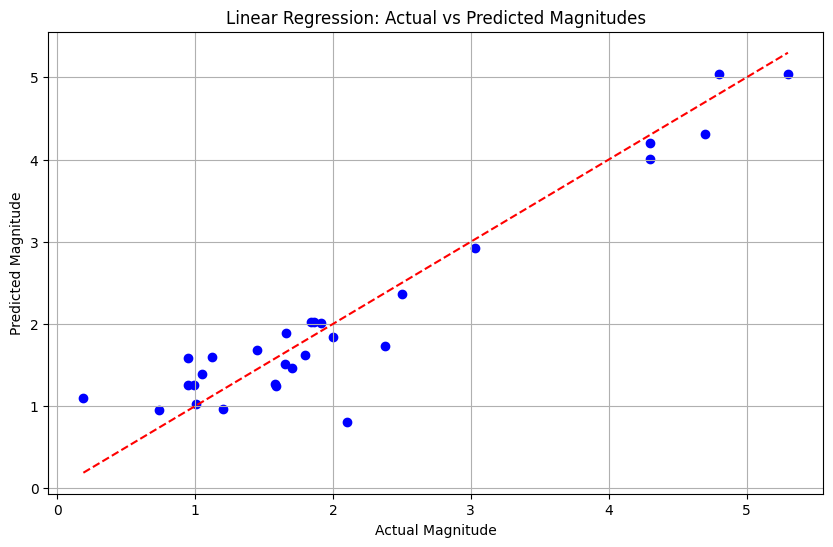

In [203]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data = final_current_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Predict on the testing data
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("prediction", "label", "features").show(5)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Visualize the predictions
actual = predictions.select("label").rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue')
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], linestyle='--', color='red')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Linear Regression: Actual vs Predicted Magnitudes')
plt.grid(True)
plt.show()


Root Mean Squared Error (RMSE) on test data with Random Forest = 0.415203


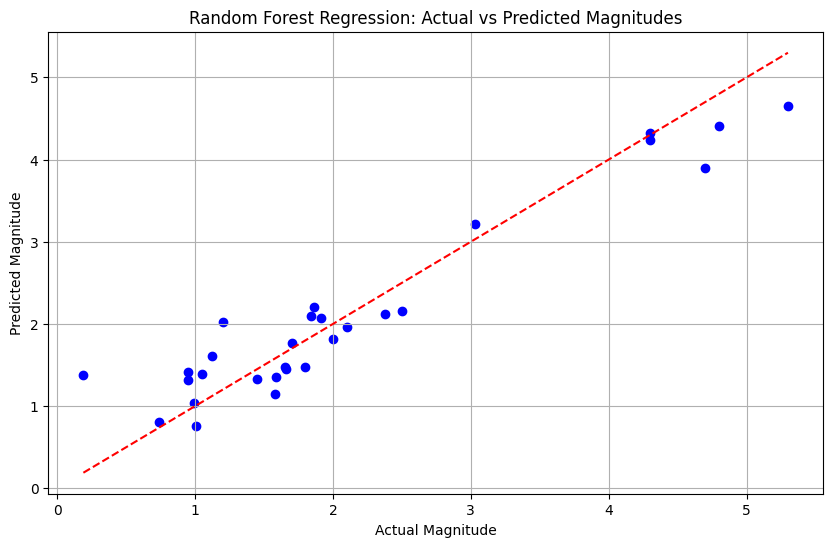

In [204]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Predict on the testing data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE
rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data with Random Forest = %g" % rf_rmse)

# Visualize the predictions
actual_rf = rf_predictions.select("label").rdd.flatMap(lambda x: x).collect()
predicted_rf = rf_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.scatter(actual_rf, predicted_rf, color='blue')
plt.plot([min(actual_rf), max(actual_rf)], [min(actual_rf), max(actual_rf)], linestyle='--', color='red')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Random Forest Regression: Actual vs Predicted Magnitudes')
plt.grid(True)
plt.show()


Root Mean Squared Error (RMSE) on test data with Random Forest = 0.415203


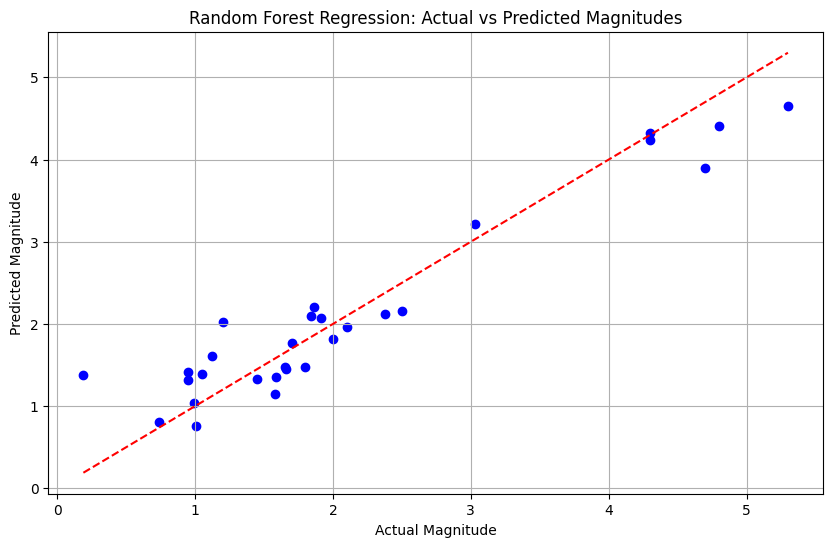

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Random Forest Regression Metrics:
Accuracy: 0.4152025743872132


In [205]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Predict on the testing data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE
rf_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data with Random Forest = %g" % rf_rmse)

# Visualize the predictions
actual_rf = rf_predictions.select("label").rdd.flatMap(lambda x: x).collect()
predicted_rf = rf_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.scatter(actual_rf, predicted_rf, color='blue')
plt.plot([min(actual_rf), max(actual_rf)], [min(actual_rf), max(actual_rf)], linestyle='--', color='red')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Random Forest Regression: Actual vs Predicted Magnitudes')
plt.grid(True)
plt.show()

# Define a threshold for earthquake occurrence
threshold = 4.0

# Convert continuous predictions to binary labels
rf_predictions = rf_predictions.withColumn("binary_prediction", when(col("prediction") >= threshold, 1.0).otherwise(0.0))

# Calculate evaluation metrics
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
rf_binary_predictions = rf_predictions.select("binary_prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
rf_multiclass_metrics = MulticlassMetrics(rf_binary_predictions)
rf_confusion_matrix = rf_multiclass_metrics.confusionMatrix().toArray()

# Calculate precision, recall, and F1 score
try:
    rf_precision = rf_multiclass_metrics.precision(label=1.0)
except:
    rf_precision = None
try:
    rf_recall = rf_multiclass_metrics.recall(label=1.0)
except:
    rf_recall = None
try:
    rf_f1_score = rf_multiclass_metrics.fMeasure(label=1.0)
except:
    rf_f1_score = None

print("Random Forest Regression Metrics:")
print("Accuracy:", rf_accuracy)


#ML

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from matplotlib.ticker import MultipleLocator
pd.options.mode.chained_assignment = None  # default='warn'

In [207]:
main = pd.read_csv("s3://bigdata-earthquake/usgs_main.csv")

In [208]:
main.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-04T21:28:02.440Z,38.759666,-122.719666,1.61,1.24,md,14.0,115.0,0.004494,0.04,...,2022-03-04T21:29:36.906Z,"3km SW of Anderson Springs, CA",earthquake,0.30,0.36,0.100,5.0,automatic,nc,nc
1,2022-03-04T21:27:28.190Z,38.833832,-122.815498,1.82,1.13,md,22.0,66.0,0.016320,0.02,...,2022-03-04T21:29:02.128Z,"8km NW of The Geysers, CA",earthquake,0.19,0.53,0.140,4.0,automatic,nc,nc
2,2022-03-04T21:25:05.130Z,35.596668,-120.271332,11.57,2.31,md,5.0,178.0,0.159000,0.01,...,2022-03-04T21:26:56.893Z,"11km SE of Shandon, CA",earthquake,3.14,3.51,0.760,3.0,automatic,nc,nc
3,2022-03-04T21:20:43.590Z,35.929167,-117.660833,3.25,0.88,ml,9.0,73.0,0.020530,0.13,...,2022-03-04T21:24:10.449Z,"22km E of Little Lake, CA",earthquake,0.33,0.74,0.055,10.0,automatic,ci,ci
4,2022-03-04T21:19:08.215Z,62.360200,-149.634500,9.80,1.40,ml,NaN,NaN,NaN,0.52,...,2022-03-04T21:22:15.794Z,"24 km NNE of Susitna North, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak


<Axes: xlabel='type'>

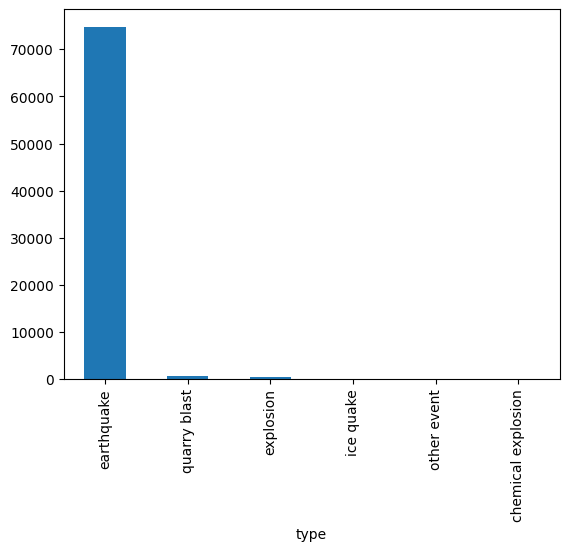

In [209]:
main['type'].value_counts().plot(kind='bar')

<Axes: xlabel='place'>

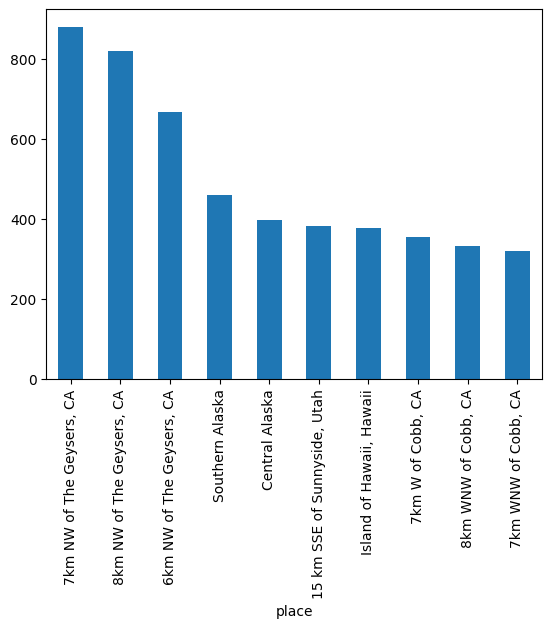

In [210]:
place_count=main['place'].value_counts()
place_count.head(10).plot(kind='bar')

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


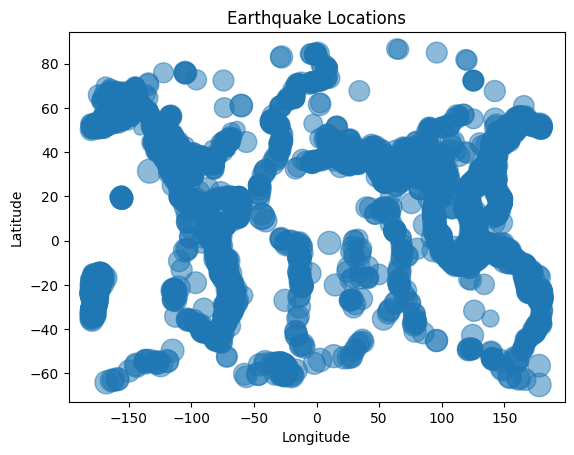

In [211]:
import matplotlib.pyplot as plt

# Extract the latitude, longitude, and magnitude columns
latitude = main['latitude']
longitude = main['longitude']
magnitude = main['mag']

# Create the scatter plot
plt.scatter(longitude, latitude, s=magnitude*50, alpha=0.5)

# Add a title and labels to the axes
plt.title('Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

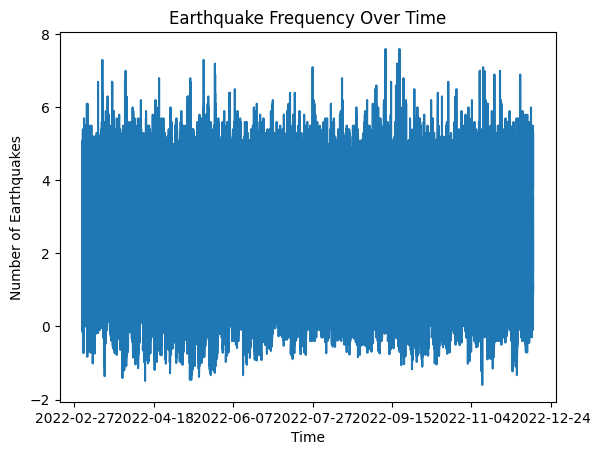

In [212]:

import matplotlib.dates as mdates

# Extract the time column
time = main['time']

# Convert the dates to numerical values
time_num = mdates.date2num(time)

# Create the line plot
plt.plot(time_num, magnitude)

# Add a title and labels to the axes
plt.title('Earthquake Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Earthquakes')

# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Show the plot
plt.show()

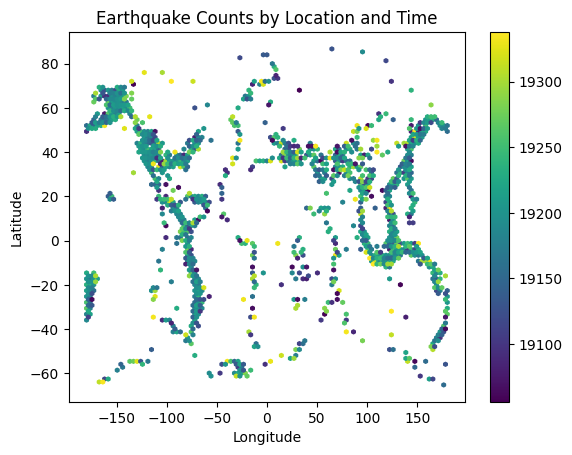

In [213]:
import matplotlib.dates as mdates

# Extract the latitude, longitude, and time columns
latitude = main['latitude']
longitude = main['longitude']
time = main['time']

# Convert the dates to numerical values
time_num = mdates.date2num(time)

# Create the heat map
plt.hexbin(longitude, latitude, C=time_num, cmap='viridis')

# Add a colorbar
plt.colorbar()

# Add a title and labels to the axes
plt.title('Earthquake Counts by Location and Time')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [214]:
state_dict = {'Alabama': 'AL',
'Alaska': 'AK',
'Arizona': 'AZ',
'Arkansas': 'AR',
'California': 'CA',
'Colorado': 'CO',
'Connecticut': 'CT',
'Delaware': 'DE',
'Florida': 'FL',
'Georgia': 'GA',
'Hawaii': 'HI',
'Idaho': 'ID',
'Illinois': 'IL',
'Indiana': 'IN',
'Iowa': 'IA',
'Kansas': 'KS',
'Kentucky': 'KY',
'Louisiana': 'LA',
'Maine': 'ME',
'Maryland': 'MD',
'Massachusetts': 'MA',
'Michigan': 'MI',
'Minnesota': 'MN',
'Mississippi': 'MS',
'Missouri': 'MO',
'Montana': 'MT',
'Nebraska': 'NE',
'Nevada': 'NV',
'New Hampshire': 'NH',
'New Jersey': 'NJ',
'New Mexico': 'NM',
'New York': 'NY',
'North Carolina': 'NC',
'North Dakota': 'ND',
'Ohio': 'OH',
'Oklahoma': 'OK',
'Oregon': 'OR',
'Pennsylvania': 'PA',
'Rhode Island': 'RI',
'South Carolina': 'SC',
'South Dakota': 'SD',
'Tennessee': 'TN',
'Texas': 'TX',
'Utah': 'UT',
'Vermont': 'VT',
'Virginia': 'VA',
'Washington': 'WA',
'West Virginia': 'WV',
'Wisconsin': 'WI',
'Wyoming': 'WY', 'Virgin Islands': 'VIRG', 'Puerto Rico':'PR'}

In [215]:
valid_indices = []
for index, row in main.iterrows():
    for x in state_dict:
        if row['place'].endswith(x):
            valid_indices.append(index)
            break
        elif row['place'].endswith(state_dict[x]):
            valid_indices.append(index)
            break

In [216]:
print(np.shape(main))
print(np.shape(valid_indices))

(75810, 22)
(68495,)


In [217]:
main[~main.index.isin(valid_indices)]

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
30,2022-03-04T17:55:37.910Z,32.0947,50.1885,11.630,4.4,mb,NaN,89.0,4.794,0.64,...,2022-03-04T20:22:50.040Z,"39 km WSW of Fārsān, Iran",earthquake,9.90,3.000,0.061,80.0,reviewed,us,us
39,2022-03-04T16:59:42.707Z,-57.4719,-25.7697,66.540,5.0,mb,NaN,82.0,6.823,0.46,...,2022-03-04T19:06:11.040Z,South Sandwich Islands region,earthquake,11.70,6.200,0.111,28.0,reviewed,us,us
56,2022-03-04T15:01:40.531Z,-7.3847,128.4873,157.850,4.9,mb,NaN,48.0,2.849,0.97,...,2022-03-04T15:27:05.040Z,"206 km NE of Lospalos, Timor Leste",earthquake,8.40,1.900,0.064,77.0,reviewed,us,us
77,2022-03-04T13:14:17.165Z,-7.2204,105.2583,35.000,4.8,mb,NaN,138.0,2.384,0.87,...,2022-03-04T13:37:46.040Z,"112 km SW of Labuan, Indonesia",earthquake,7.20,2.000,0.082,46.0,reviewed,us,us
101,2022-03-04T10:46:14.761Z,27.1745,53.2459,10.000,4.4,mb,NaN,103.0,3.465,0.44,...,2022-03-04T11:02:42.040Z,"55 km SE of Mohr, Iran",earthquake,9.10,1.900,0.089,36.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75775,2022-12-12T18:37:10.959Z,-7.0568,124.7846,541.655,4.8,mb,63.0,55.0,2.730,0.52,...,2022-12-12T18:52:03.040Z,"178 km NNW of Maubara, Timor Leste",earthquake,9.56,7.044,0.070,63.0,reviewed,us,us
75788,2022-12-12T18:52:42.487Z,-11.8648,-73.9890,102.538,4.6,mb,23.0,111.0,2.795,0.65,...,2022-12-12T20:00:16.040Z,"83 km SE of Mazamari, Peru",earthquake,6.25,11.527,0.152,13.0,reviewed,us,us
75791,2022-12-12T19:18:06.311Z,32.0240,141.8060,10.000,4.9,mb,95.0,101.0,2.003,0.70,...,2022-12-12T20:30:07.040Z,"Izu Islands, Japan region",earthquake,10.01,1.871,0.048,139.0,reviewed,us,us
75793,2022-12-12T19:43:35.652Z,-5.9985,149.3020,79.725,4.6,mb,21.0,111.0,3.369,0.41,...,2022-12-12T20:42:01.040Z,"35 km NW of Kandrian, Papua New Guinea",earthquake,10.99,5.259,0.151,13.0,reviewed,us,us


In [218]:
US_df = main[main.index.isin(valid_indices)]
states = []
for row in US_df['place']:
    for x in state_dict:
        if row.endswith(x):
            states.append(x)
            break
        elif row.endswith(state_dict[x]):
            states.append(x)
            break
US_df['state'] = states
US_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,state
0,2022-03-04T21:28:02.440Z,38.759666,-122.719666,1.61,1.24,md,14.0,115.00,0.004494,0.0400,...,"3km SW of Anderson Springs, CA",earthquake,0.30,0.36,0.100,5.0,automatic,nc,nc,California
1,2022-03-04T21:27:28.190Z,38.833832,-122.815498,1.82,1.13,md,22.0,66.00,0.016320,0.0200,...,"8km NW of The Geysers, CA",earthquake,0.19,0.53,0.140,4.0,automatic,nc,nc,California
2,2022-03-04T21:25:05.130Z,35.596668,-120.271332,11.57,2.31,md,5.0,178.00,0.159000,0.0100,...,"11km SE of Shandon, CA",earthquake,3.14,3.51,0.760,3.0,automatic,nc,nc,California
3,2022-03-04T21:20:43.590Z,35.929167,-117.660833,3.25,0.88,ml,9.0,73.00,0.020530,0.1300,...,"22km E of Little Lake, CA",earthquake,0.33,0.74,0.055,10.0,automatic,ci,ci,California
4,2022-03-04T21:19:08.215Z,62.360200,-149.634500,9.80,1.40,ml,NaN,NaN,NaN,0.5200,...,"24 km NNE of Susitna North, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak,Alaska
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75804,2022-12-12T21:08:56.860Z,19.283300,-64.906100,24.00,3.55,md,7.0,300.00,0.931600,0.3200,...,"104 km N of Charlotte Amalie, U.S. Virgin Islands",earthquake,1.85,26.66,0.140,3.0,reviewed,pr,pr,Virgin Islands
75805,2022-12-12T08:04:39.081Z,38.248400,-118.357200,10.00,0.60,ml,10.0,148.98,0.116000,0.1196,...,"26 km SW of Mina, Nevada",earthquake,NaN,2.90,0.000,1.0,reviewed,nn,nn,Nevada
75806,2022-12-12T08:00:43.492Z,36.789300,-116.224700,5.10,0.10,ml,11.0,94.63,0.038000,0.0884,...,"49 km ESE of Beatty, Nevada",earthquake,NaN,2.30,0.430,7.0,reviewed,nn,nn,Nevada
75807,2022-12-12T22:36:07.230Z,33.032667,-116.396500,9.19,0.93,ml,17.0,77.00,0.110400,0.2600,...,"20km ESE of Julian, CA",earthquake,0.44,1.83,0.148,10.0,automatic,ci,ci,California


In [219]:
US_df = US_df.drop(['gap', 'id', 'locationSource', 'magSource', 'nst', 'dmin', 'net', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst', 'updated', 'status'], axis=1)
US_df

,time,latitude,longitude,depth,mag,magType,place,type,state
0,2022-03-04T21:28:02.440Z,38.759666,-122.719666,1.61,1.24,md,"3km SW of Anderson Springs, CA",earthquake,California
1,2022-03-04T21:27:28.190Z,38.833832,-122.815498,1.82,1.13,md,"8km NW of The Geysers, CA",earthquake,California
2,2022-03-04T21:25:05.130Z,35.596668,-120.271332,11.57,2.31,md,"11km SE of Shandon, CA",earthquake,California
3,2022-03-04T21:20:43.590Z,35.929167,-117.660833,3.25,0.88,ml,"22km E of Little Lake, CA",earthquake,California
4,2022-03-04T21:19:08.215Z,62.360200,-149.634500,9.80,1.40,ml,"24 km NNE of Susitna North, Alaska",earthquake,Alaska
...,...,...,...,...,...,...,...,...,...
75804,2022-12-12T21:08:56.860Z,19.283300,-64.906100,24.00,3.55,md,"104 km N of Charlotte Amalie, U.S. Virgin Islands",earthquake,Virgin Islands
75805,2022-12-12T08:04:39.081Z,38.248400,-118.357200,10.00,0.60,ml,"26 km SW of Mina, Nevada",earthquake,Nevada
75806,2022-12-12T08:00:43.492Z,36.789300,-116.224700,5.10,0.10,ml,"49 km ESE of Beatty, Nevada",earthquake,Nevada
75807,2022-12-12T22:36:07.230Z,33.032667,-116.396500,9.19,0.93,ml,"20km ESE of Julian, CA",earthquake,California


In [220]:
severity = []
for x in US_df['mag']:
    if x <= 3.9:
        severity.append('not felt')
    elif x <= 4.9:
        severity.append('small')
    elif x <= 5.9:
        severity.append('moderate')
    else:
        severity.append('strong')
US_df['severity'] = severity

In [221]:
depth_category = []
for x in US_df['depth']:
    if x <= 70:
        depth_category.append('shallow')
    elif x <= 300:
        depth_category.append('intermediate')
    else:
        depth_category.append('deep')
US_df['depth category'] = depth_category

In [222]:
US_df.to_csv(r'export_dataframe.csv')

In [223]:
US_df.isnull().sum()

time               0
latitude           0
longitude          0
depth              0
mag               14
magType           14
place              0
type               0
state              0
severity           0
depth category     0
dtype: int64

In [224]:
null_mag = US_df[US_df['mag'].isnull()].index
US_df.drop(null_mag, inplace = True)
US_df.isnull().sum()

time              0
latitude          0
longitude         0
depth             0
mag               0
magType           0
place             0
type              0
state             0
severity          0
depth category    0
dtype: int64

In [225]:
print('most recent recording = ' + str(US_df['time'].max()))
print('oldest recording = ' + str(US_df['time'].min()))

most recent recording = 2022-12-12T22:36:07.230Z
oldest recording = 2022-03-03T21:37:08.970Z


In [226]:
print(US_df[(US_df['latitude'] < -90) | (US_df['latitude'] > 90)])
print(US_df[(US_df['longitude'] < -180) | (US_df['longitude'] > 180)])

Empty DataFrame
Columns: [time, latitude, longitude, depth, mag, magType, place, type, state, severity, depth category]
Index: []
Empty DataFrame
Columns: [time, latitude, longitude, depth, mag, magType, place, type, state, severity, depth category]
Index: []


In [227]:
print('The deepest earthquake reading was at ' + str(US_df['depth'].max())+'km')
print('The shallowest earthquake reading was at ' + str(US_df['depth'].min())+'km')

The deepest earthquake reading was at 274.7km
The shallowest earthquake reading was at -3.8km


In [228]:
print('Original value counts for magnitude types:')
print(US_df['magType'].value_counts())
US_df['magType'].replace(['Ml', 'mww', 'Mb'],['ml', 'mw', 'mb'], inplace = True)
print('Corrected value counts for magnitude types:')
print(US_df['magType'].value_counts())

Original value counts for magnitude types:
magType
ml       43344
md       24598
mb         244
mb_lg      125
mh          52
mw          32
mlv         25
mww         17
mwr         16
Ml          12
mlr         11
Mi           3
Mb           2
Name: count, dtype: int64
Corrected value counts for magnitude types:
magType
ml       43356
md       24598
mb         246
mb_lg      125
mh          52
mw          49
mlv         25
mwr         16
mlr         11
Mi           3
Name: count, dtype: int64


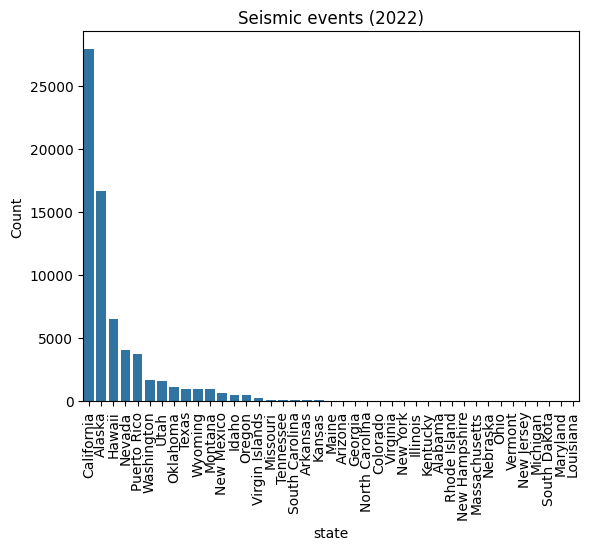

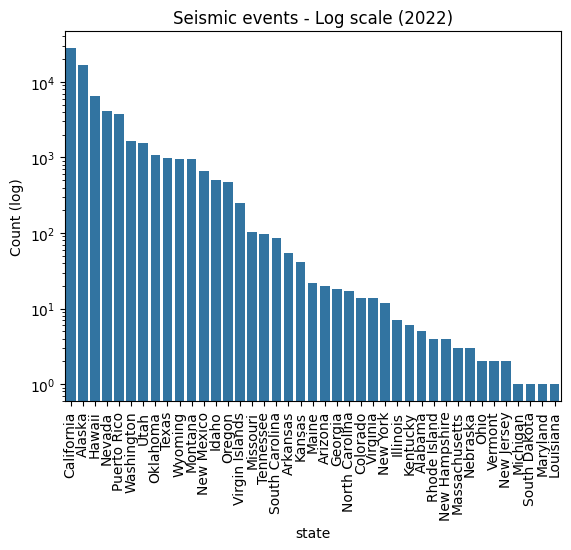

In [229]:
sns.countplot(x = 'state', data = US_df, order = US_df['state'].value_counts(ascending = False).index)
plt.xlabel('state')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Seismic events (2022)')
plt.show()

sns.countplot(x = 'state', data = US_df, order = US_df['state'].value_counts(ascending = False).index)
plt.xlabel('state')
plt.xticks(rotation = 90)
plt.title('Seismic events - Log scale (2022)')
plt.yscale('log')
plt.ylabel('Count (log)')
plt.show()

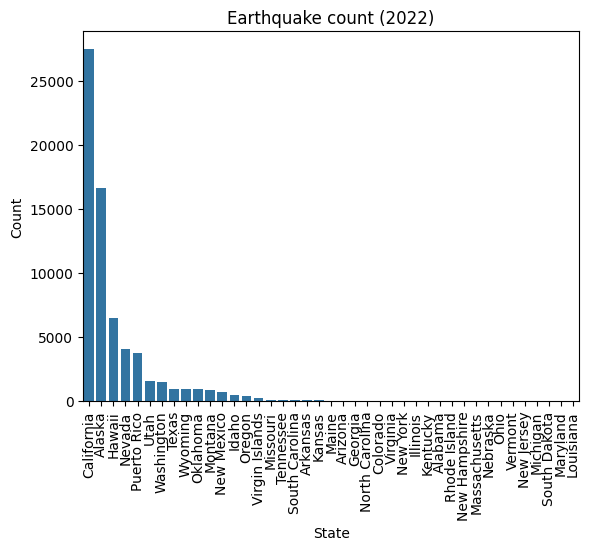

In [230]:
earthquakes = US_df[US_df['type'] =='earthquake']
'''Creates a new dataframe containing only earthquakes'''
sns.countplot(x = 'state', data = earthquakes, order = earthquakes['state'].value_counts(ascending=False).index)
plt.xlabel('State')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Earthquake count (2022)')
plt.show()

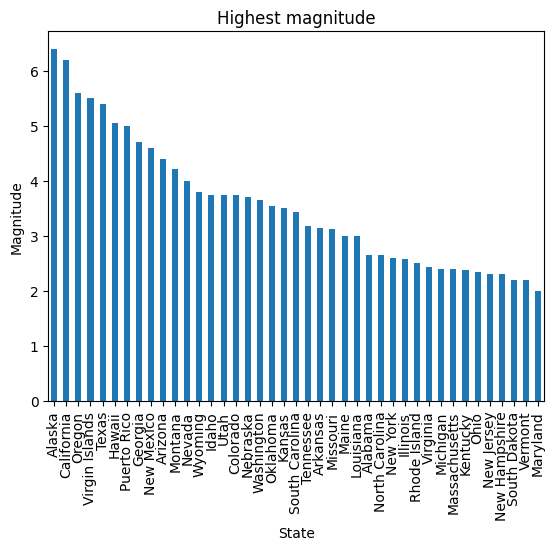

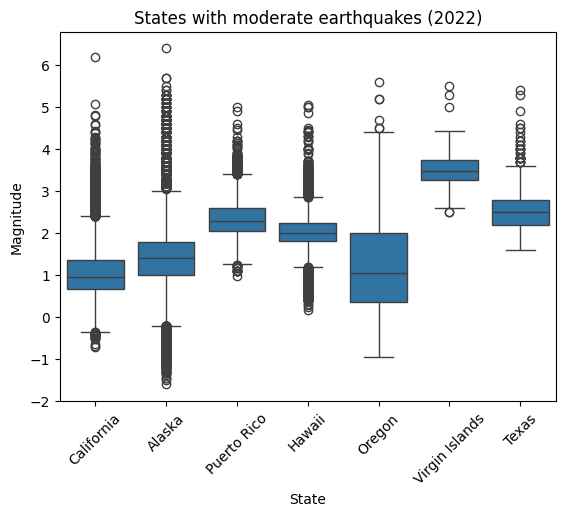

In [231]:
US_df.groupby('state')['mag'].max().sort_values(ascending = False).plot(kind = 'bar', xlabel = 'State', ylabel = 'Magnitude', title = 'Highest magnitude')
'''Returns the highest recorded earthquake magnitude for each state'''
plt.xticks(rotation = 90)
plt.show()

max_mags = pd.DataFrame(earthquakes.groupby('state')['mag'].max()).reset_index()
'''Creates a df with the max magnitude recorded for each state'''
mod_quake_states = max_mags[max_mags['mag'] >= 5.0]
'''Subsets this df for states whose max magnitude is >= 5.0'''
earthquakes_to_analyze = earthquakes[earthquakes['state'].isin(mod_quake_states['state'])]
'''Subsets the original df for all records pertaining to the states whose max magnitude is >= 5.0'''

sns.boxplot(x = 'state', y = 'mag', data = earthquakes_to_analyze).set(xlabel='State', ylabel = 'Magnitude')
plt.title('States with moderate earthquakes (2022)')
plt.xticks(rotation = 45)
plt.show()

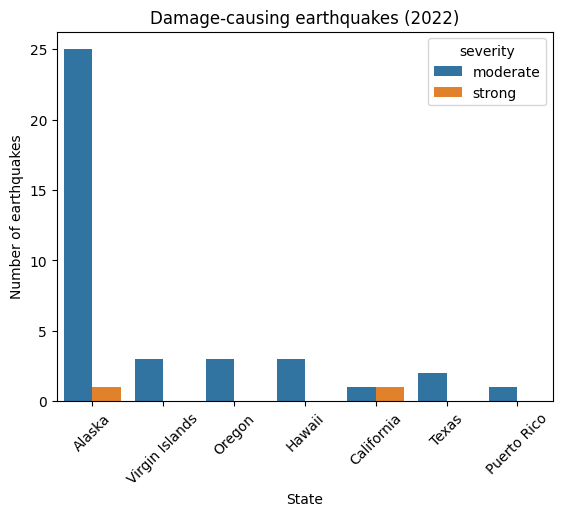

In [232]:
moderate_and_strong = earthquakes_to_analyze[earthquakes_to_analyze['severity'].isin(['moderate', 'strong'])]
'''Subsets our dataframe of relevant  earthquakes for those that are considered moderate or strong'''
sns.countplot(x = 'state', data = moderate_and_strong, hue = 'severity').set(xlabel = 'State', ylabel = 'Number of earthquakes')
plt.title('Damage-causing earthquakes (2022)')
plt.xticks(rotation = 45)
plt.show()

In [233]:
california_earthquakes = earthquakes_to_analyze[earthquakes_to_analyze['state'] == 'California']
'''Create a new dataframe with only California earthquakes, and identify the date/time when the strong earthquake occured'''
california_earthquakes[california_earthquakes['severity'] == 'strong']

,time,latitude,longitude,depth,mag,magType,place,type,state,severity,depth category
65786,2022-11-04T10:02:48.196Z,28.142,-112.3013,10.0,6.2,mw,Gulf of California,earthquake,California,strong,shallow


In [234]:
alaska_earthquakes = earthquakes_to_analyze[earthquakes_to_analyze['state'] == 'Alaska']
'''Create a new dataframe with only Alaska earthquakes, and identify the date/time when the strong earthquake occured'''
alaska_earthquakes[alaska_earthquakes['severity'] == 'strong']

,time,latitude,longitude,depth,mag,magType,place,type,state,severity,depth category
24647,2022-06-04T23:38:13.064Z,52.067,178.2804,104.6,6.4,mw,"Rat Islands, Aleutian Islands, Alaska",earthquake,Alaska,strong,intermediate


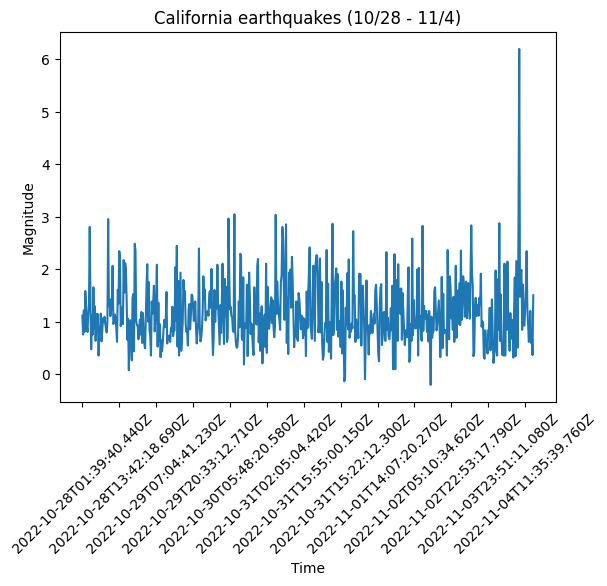

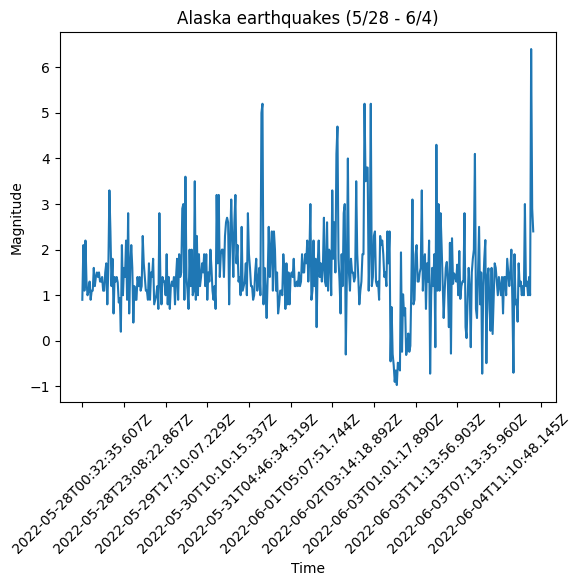

In [235]:
cali_strong_quake = california_earthquakes[(california_earthquakes['time'] >= '2022-10-28') & (california_earthquakes['time'] <= '2022-11-04T12:00:00')]
'''Creates a new dataframe containing all earthquakes that occured in California in the week leading up to the strong earthquake'''
sns.lineplot(data = cali_strong_quake, x = 'time', y = 'mag').xaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.ylabel('Magnitude')
plt.title('California earthquakes (10/28 - 11/4)')
plt.show()

alaska_strong_quake = alaska_earthquakes[(alaska_earthquakes['time'] >= '2022-05-28') & (alaska_earthquakes['time'] < '2022-06-05')]
'''Creates a new dataframe containing all earthquakes that occured in Alaska in the week leading up to the strong earthquake'''
sns.lineplot(data = alaska_strong_quake, x = 'time', y = 'mag').xaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.ylabel('Magnitude')
plt.title('Alaska earthquakes (5/28 - 6/4)')
plt.show()

Average quarry blast mag: 1.393057471264368
Quarry blast mag std dev: 0.29094073956466304
Highest mag in this timeframe: nan
Highest overall mag: 2.34


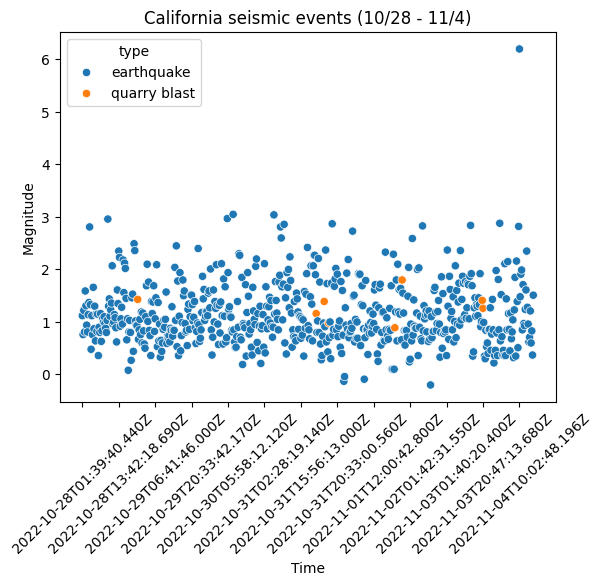

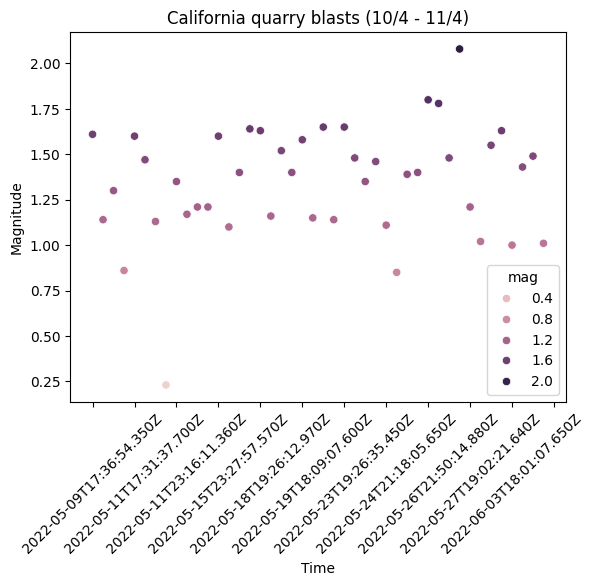

In [236]:

california_seismic = US_df[US_df['state'] == 'California']
'''Subsets original dataframe for all seismic events in California'''
cali_quarry = california_seismic[california_seismic['type'] =='quarry blast']
'''Creates a new dataframe containing only the quarry blasts in California'''
print('Average quarry blast mag: ' + str(np.mean(cali_quarry['mag'])))
print('Quarry blast mag std dev: ' + str(np.std(cali_quarry['mag'])))
print('Highest mag in this timeframe: ' + str(cali_strong_quake[cali_strong_quake['type'] == 'quarry blast']['mag'].max()))
print('Highest overall mag: ' + str(cali_quarry['mag'].max()))
cali_strong_quake = california_seismic[(california_seismic['time'] >= '2022-10-28') & (california_seismic['time'] <= '2022-11-04T12:00:00')]
'''Creates a new dataframe containing California seismic events within the same timeframe as before: 1 week leading up to the strong earthquake'''
sns.scatterplot(data = cali_strong_quake, x = 'time', y = 'mag', hue = 'type').xaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('California seismic events (10/28 - 11/4)')
plt.xticks(rotation = 45)
plt.show()

cali_quarry_time = cali_quarry[(cali_quarry['time'] >= '2022-05-05') & (cali_quarry['time'] < '2022-06-05')]
'''Creates a new dataframe containing California seismic events within the same timeframe as before: 1 week leading up to the strong earthquake'''
sns.scatterplot(data = cali_quarry_time, x = 'time', y = 'mag', hue = 'mag').xaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('California quarry blasts (10/4 - 11/4)')
plt.xticks(rotation = 45)
plt.show()

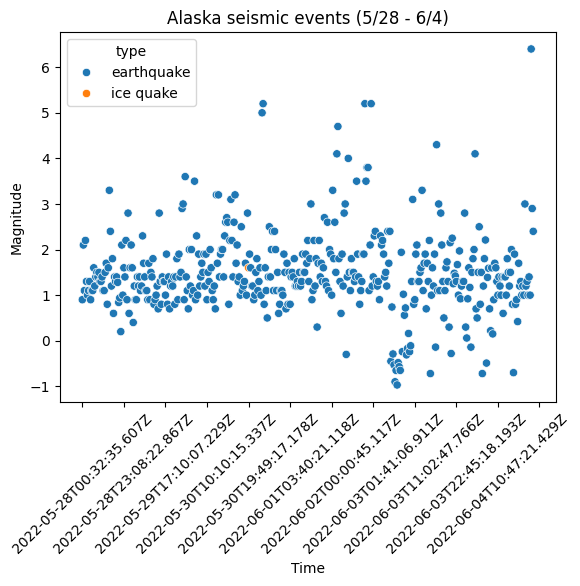

In [237]:
alaska_seismic = US_df[US_df['state'] == 'Alaska']
'''Creates a new dataframe containing all seismic activity in Alaska'''
alaska_strong_quake = alaska_seismic[(alaska_seismic['time'] >= '2022-05-28') & (alaska_seismic['time'] < '2022-06-05')]
'''Subsets the dataframe above for all seismic activity in Alaska which occured in the week leading up to the strong earthquake'''
sns.scatterplot(data = alaska_strong_quake, x = 'time', y = 'mag', hue = 'type').xaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.ylabel('Magnitude')
plt.title('Alaska seismic events (5/28 - 6/4)')
plt.show()

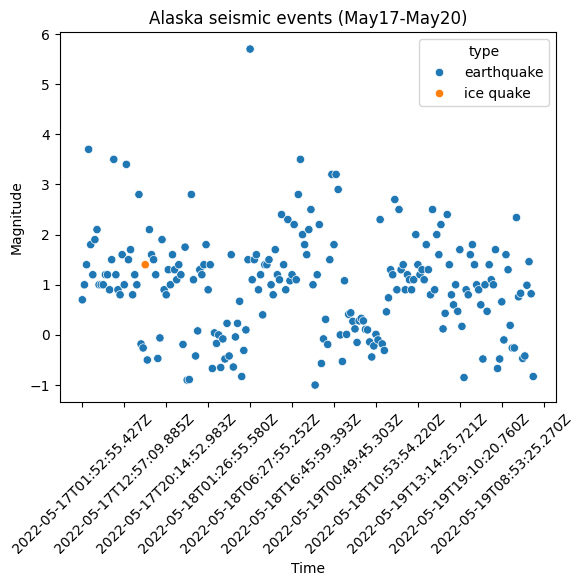

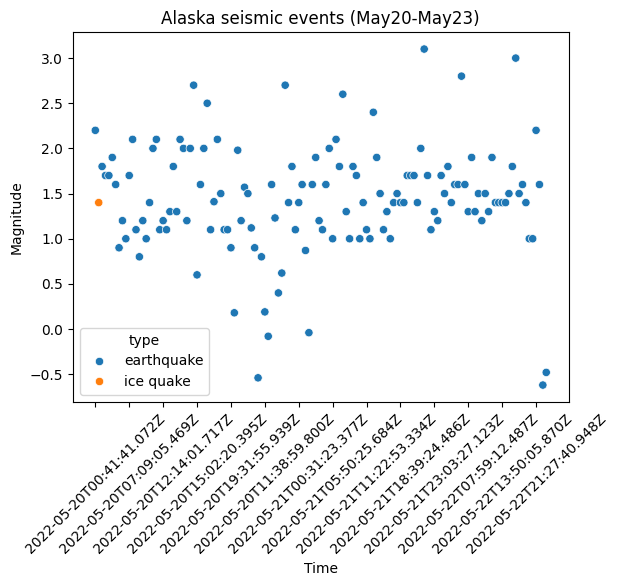

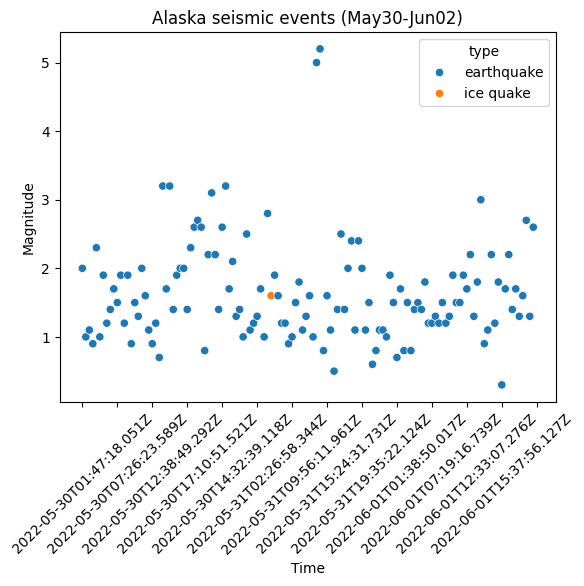

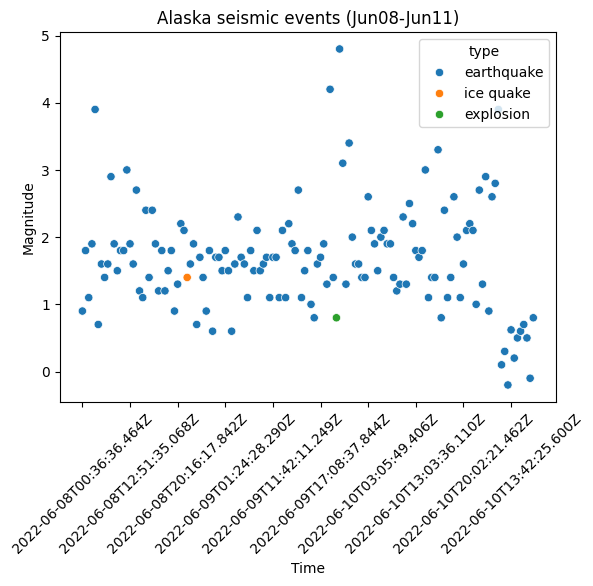

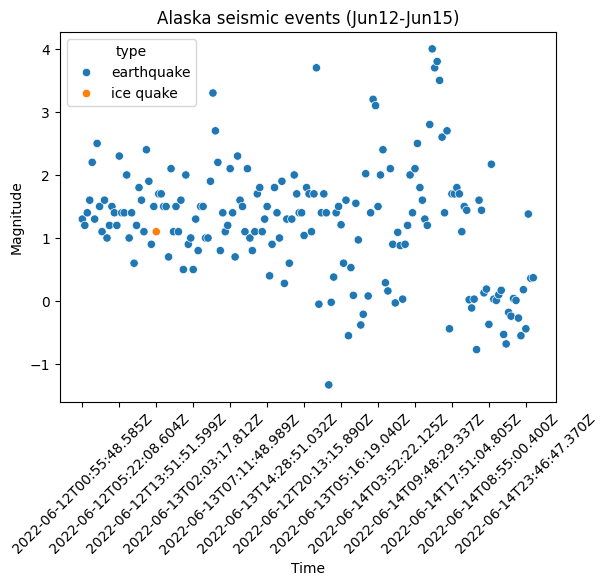

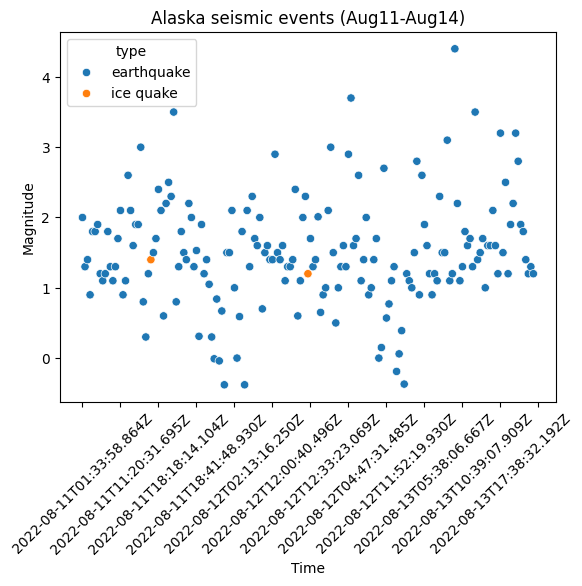

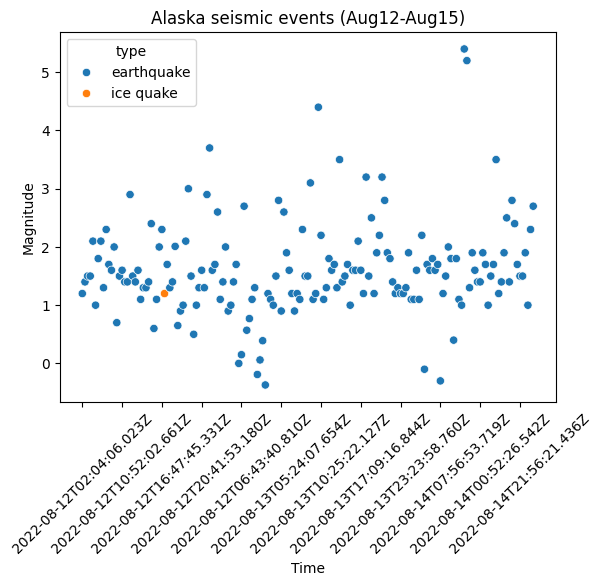

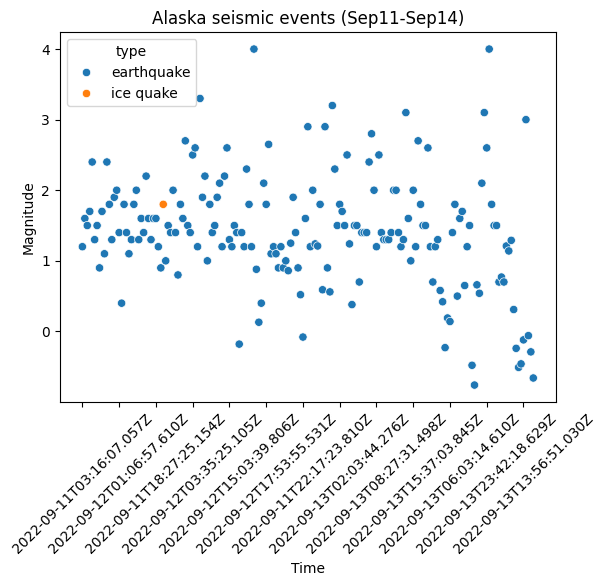

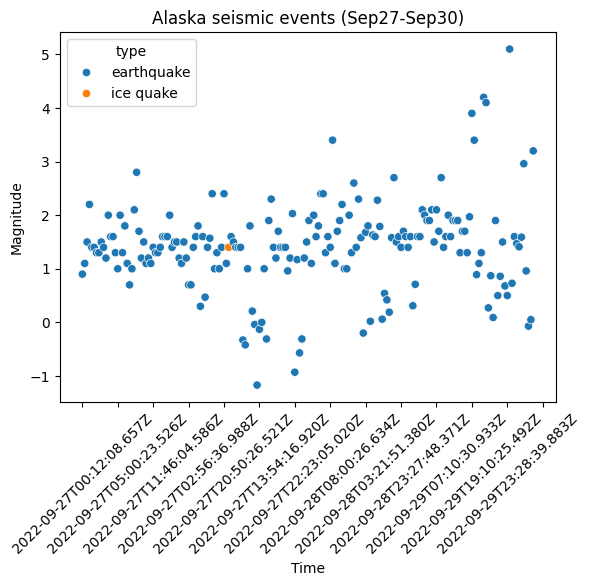

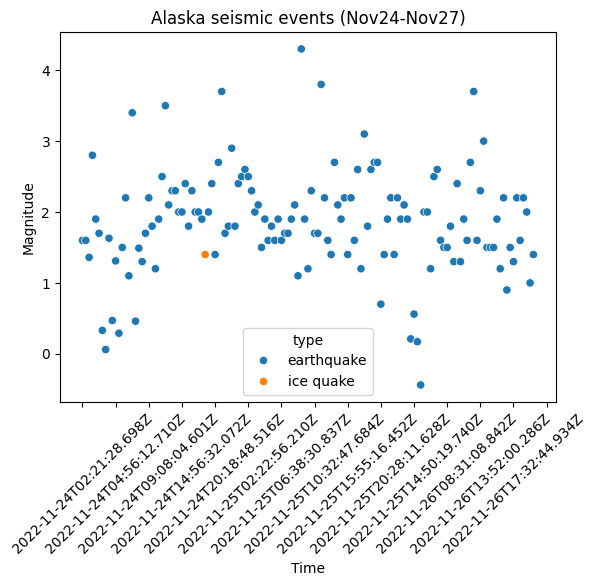

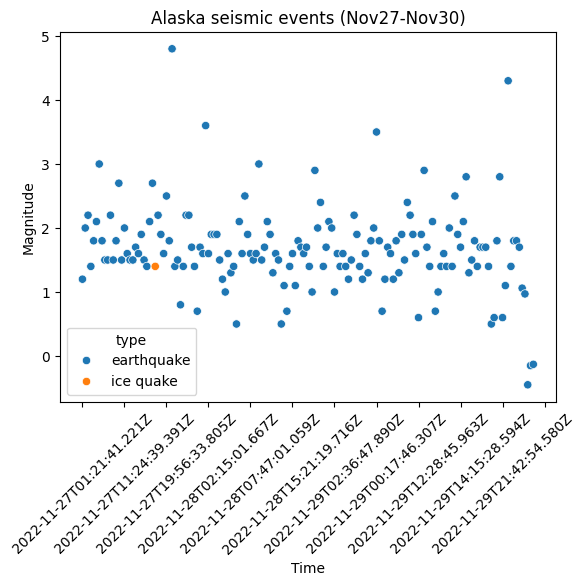

In [238]:
alaska_icequakes = alaska_seismic[alaska_seismic['type'] == 'ice quake']
'''Creates a new df containing only the icequakes in Alaska'''

def plot_mag_future(df1, df2, time_col, n_days, state):
    '''Iterates over the time_col in df1, creating a start date and an end date n_days later. Subsets df2 for this window, and creates a scatter plot of magnitude by time_col'''
    for x in df1[time_col]:
        start_date = pd.to_datetime(x).date()
        end_date = start_date + timedelta(days = n_days)
        timeframe = df2[(df2[time_col] >= str(start_date)) & (df2[time_col] < str(end_date))]
        sns.scatterplot(data = timeframe, x = time_col, y = 'mag', hue = 'type').xaxis.set_major_locator(plt.MaxNLocator(15))
        plt.xlabel('Time')
        plt.xticks(rotation = 45)
        plt.ylabel('Magnitude')
        plt.title(state + ' seismic events ' + '(' + start_date.strftime('%b%d') + '-' + end_date.strftime('%b%d') + ')')
        plt.show()

plot_mag_future(alaska_icequakes, alaska_seismic, 'time', 3, 'Alaska')